## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import cv2
from PIL import Image
import joblib
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)

2.18.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaydendwinaufal","key":"b3271d7969a9e55a4cb4958eaa8037ad"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d hendryhb/batik-nusantara-batik-indonesia-dataset
!unzip batik-nusantara-batik-indonesia-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hendryhb/batik-nusantara-batik-indonesia-dataset
License(s): CC0-1.0
Archive:  batik-nusantara-batik-indonesia-dataset.zip
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0010.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0016.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0020.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0021.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0023.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0026.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/0030.jpg  
  inflating: raw_batik_v2.1/test/Aceh_Pintu_Aceh/007.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/0010.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/0014.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/0018.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/0028.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/003.jpg  
  inflating: raw_batik_v2.1/test/Bali_Barong/0034.jpg  
  inflating: raw_b

In [5]:
train_dir = "raw_batik_v2.1/train"
test_dir = "raw_batik_v2.1/test"

comb_dir = "all-batik/dataset"

os.makedirs(comb_dir, exist_ok=True)

In [6]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(comb_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(comb_dir, category), dirs_exist_ok=True)

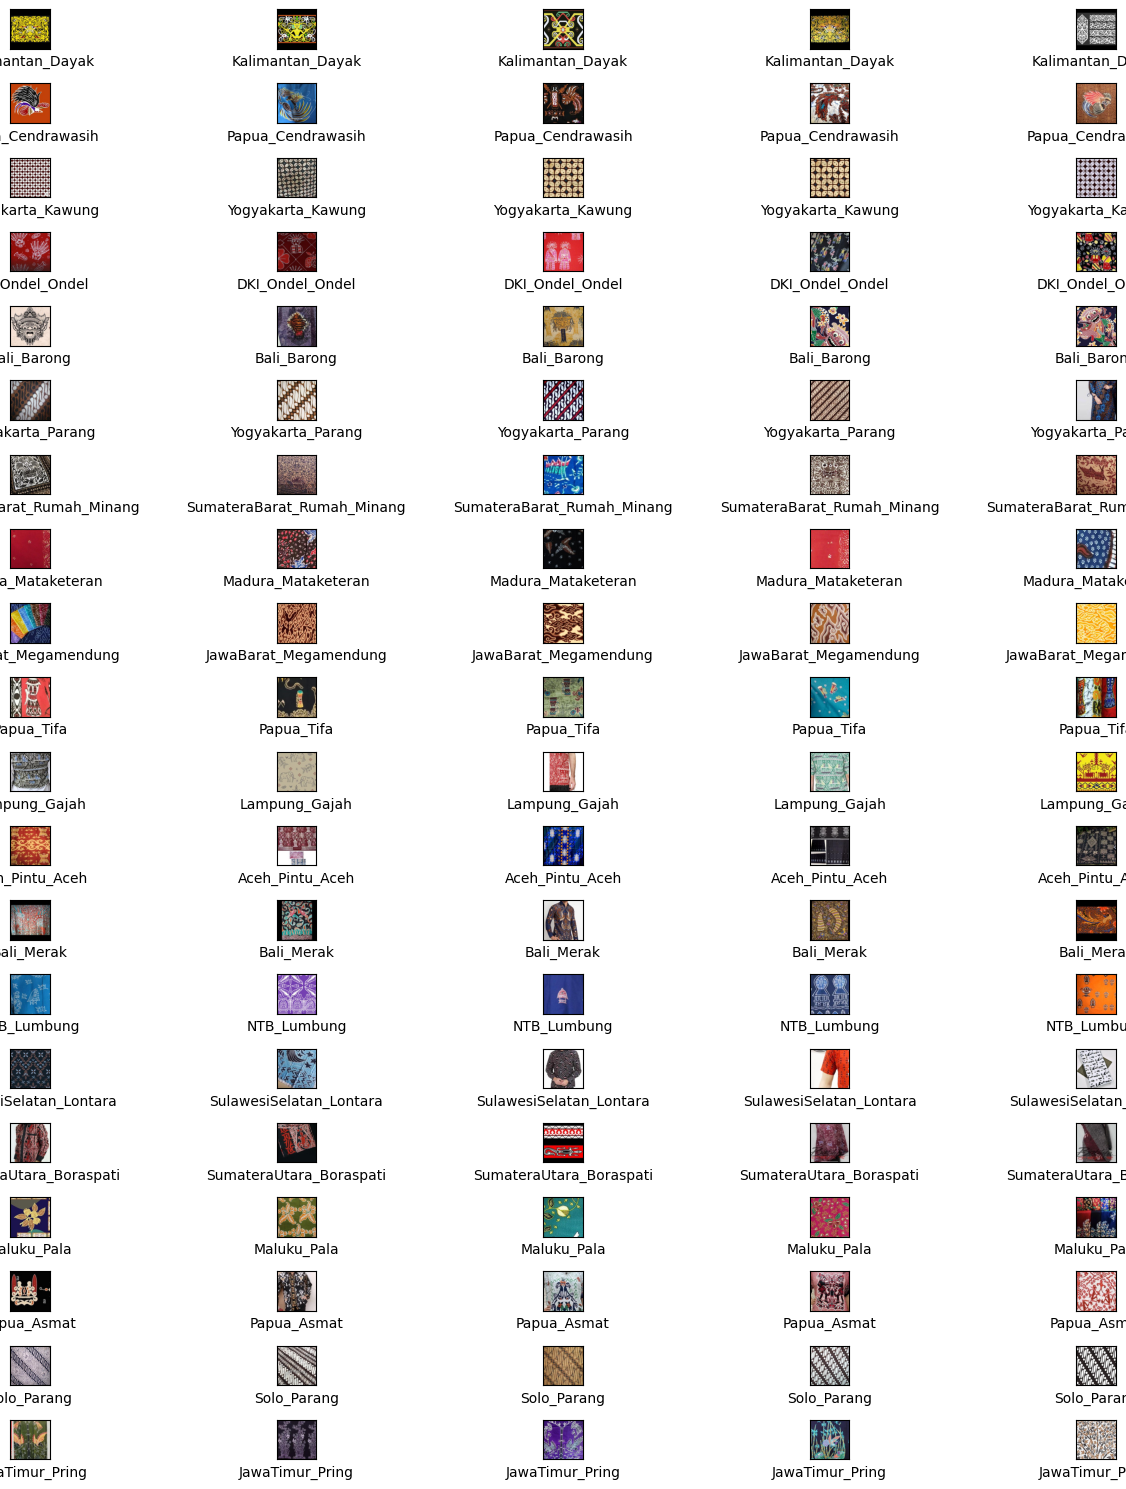

In [7]:
batik_image = {}

path = "all-batik/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    # Get a list of image files in the current class directory
    image_files = [f for f in os.listdir(os.path.join(path_sub, i)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # Only add the class to batik_image if it contains images
    if image_files:
        batik_image[i] = image_files

path_sub = "all-batik/dataset"

fig, axs = plt.subplots(len(batik_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(batik_image.keys()): # Changed os.listdir to batik_image.keys()
    # Check if the class has any images before trying to sample
    if class_name in batik_image and batik_image[class_name]:
        images = np.random.choice(batik_image[class_name], 5, replace=False)

        for j, image_name in enumerate(images):
            img_path = os.path.join(path_sub, class_name, image_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
    else:
        print(f"Skipping class '{class_name}' because it has no images.")

fig.tight_layout()

In [8]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [30]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = { 'anticlockwise_rotation': anticlockwise_rotation,
                    'clockwise_rotation': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path = "all-batik/dataset/Yogyakarta_Parang" # Path untuk gambar asli

augmented_path="all-batik/dataset/Yogyakarta_Parang" # Path untuk gambar yang sudah diaugmenti
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))
# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
images_to_generate=500
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

    # 'aceh': os.path.join(TRAIN_DIR, 'Aceh_Pintu_Aceh'),
    # 'bali_barong': os.path.join(TRAIN_DIR, 'Bali_Barong'),
    # 'bali_merak': os.path.join(TRAIN_DIR, 'Bali_Merak'),
    # 'dki': os.path.join(TRAIN_DIR, 'DKI_Ondel_Ondel'),
    # 'jabar': os.path.join(TRAIN_DIR, 'JawaBarat_Megamendung'),
    # 'jatim': os.path.join(TRAIN_DIR, 'JawaTimur_Pring'),
    # 'kalimantan': os.path.join(TRAIN_DIR, 'Kalimantan_Dayak'),
    # 'lampung': os.path.join(TRAIN_DIR, 'Lampung_Gajah'),
    # 'madura': os.path.join(TRAIN_DIR, 'Madura_Mataketeran'),
    # 'maluku': os.path.join(TRAIN_DIR, 'Maluku_Pala'),
    # 'ntb': os.path.join(TRAIN_DIR, 'NTB_Lumbung'),
    # 'papua_asmat': os.path.join(TRAIN_DIR, 'Papua_Asmat'),
    # 'papua_cendrawasih': os.path.join(TRAIN_DIR, 'Papua_Cendrawasih'),
    # 'papua_tifa': os.path.join(TRAIN_DIR, 'Papua_Tifa'),
    # 'solo': os.path.join(TRAIN_DIR, 'Solo_Parang'),
    # 'sulawesi': os.path.join(TRAIN_DIR, 'SulawesiSelatan_Lontara'),
    # 'sumatera_barat': os.path.join(TRAIN_DIR, 'SumateraBarat_Rumah_Minang'),
    # 'sumatera_utara': os.path.join(TRAIN_DIR, 'SumateraUtara_Boraspati'),
    # 'yogyakarta_kawung': os.path.join(TRAIN_DIR, 'Yogyakarta_Kawung'),
    # 'yogyakarta_parang': os.path.join(TRAIN_DIR, 'Yogyakarta_Parang'),


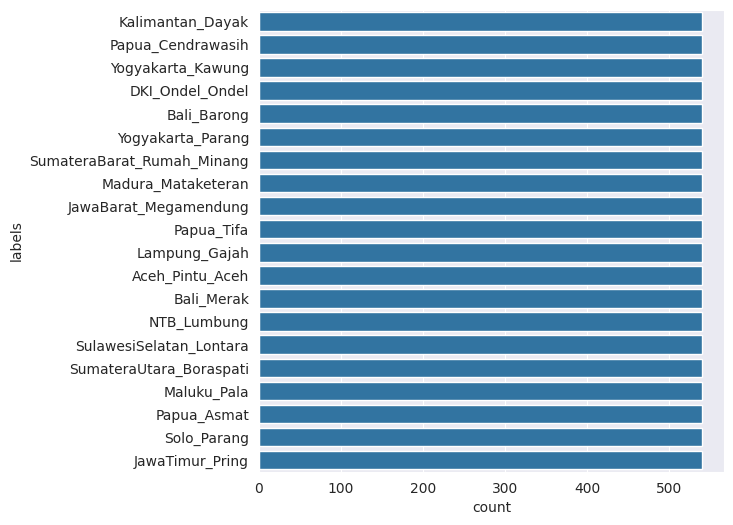

In [31]:
batik_path = "all-batik/dataset"

fileName = []
labels =[]
fullPath =[]

for path, subdirs, files in os.walk(batik_path):
    for name in files:
        fullPath.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        fileName.append(name)


df = pd.DataFrame({"path":fullPath, 'file_name':fileName, "labels":labels})
Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [32]:
X = df['path']
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [34]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)
datasource_path = "all-batik/dataset/"
dataset_path = "Dataset-Final/"

In [35]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

#### Split Dataset

In [36]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_paths = {
    'aceh': os.path.join(TRAIN_DIR, 'Aceh_Pintu_Aceh'),
    'bali_barong': os.path.join(TRAIN_DIR, 'Bali_Barong'),
    'bali_merak': os.path.join(TRAIN_DIR, 'Bali_Merak'),
    'dki': os.path.join(TRAIN_DIR, 'DKI_Ondel_Ondel'),
    'jabar': os.path.join(TRAIN_DIR, 'JawaBarat_Megamendung'),
    'jatim': os.path.join(TRAIN_DIR, 'JawaTimur_Pring'),
    'kalimantan': os.path.join(TRAIN_DIR, 'Kalimantan_Dayak'),
    'lampung': os.path.join(TRAIN_DIR, 'Lampung_Gajah'),
    'madura': os.path.join(TRAIN_DIR, 'Madura_Mataketeran'),
    'maluku': os.path.join(TRAIN_DIR, 'Maluku_Pala'),
    'ntb': os.path.join(TRAIN_DIR, 'NTB_Lumbung'),
    'papua_asmat': os.path.join(TRAIN_DIR, 'Papua_Asmat'),
    'papua_cendrawasih': os.path.join(TRAIN_DIR, 'Papua_Cendrawasih'),
    'papua_tifa': os.path.join(TRAIN_DIR, 'Papua_Tifa'),
    'solo': os.path.join(TRAIN_DIR, 'Solo_Parang'),
    'sulawesi': os.path.join(TRAIN_DIR, 'SulawesiSelatan_Lontara'),
    'sumatera_barat': os.path.join(TRAIN_DIR, 'SumateraBarat_Rumah_Minang'),
    'sumatera_utara': os.path.join(TRAIN_DIR, 'SumateraUtara_Boraspati'),
    'yogyakarta_kawung': os.path.join(TRAIN_DIR, 'Yogyakarta_Kawung'),
    'yogyakarta_parang': os.path.join(TRAIN_DIR, 'Yogyakarta_Parang'),
}

test_paths = {
    'aceh': os.path.join(TEST_DIR, 'Aceh_Pintu_Aceh'),
    'bali_barong': os.path.join(TEST_DIR, 'Bali_Barong'),
    'bali_merak': os.path.join(TEST_DIR, 'Bali_Merak'),
    'dki': os.path.join(TEST_DIR, 'DKI_Ondel_Ondel'),
    'jabar': os.path.join(TEST_DIR, 'JawaBarat_Megamendung'),
    'jatim': os.path.join(TEST_DIR, 'JawaTimur_Pring'),
    'kalimantan': os.path.join(TEST_DIR, 'Kalimantan_Dayak'),
    'lampung': os.path.join(TEST_DIR, 'Lampung_Gajah'),
    'madura': os.path.join(TEST_DIR, 'Madura_Mataketeran'),
    'maluku': os.path.join(TEST_DIR, 'Maluku_Pala'),
    'ntb': os.path.join(TEST_DIR, 'NTB_Lumbung'),
    'papua_asmat': os.path.join(TEST_DIR, 'Papua_Asmat'),
    'papua_cendrawasih': os.path.join(TEST_DIR, 'Papua_Cendrawasih'),
    'papua_tifa': os.path.join(TEST_DIR, 'Papua_Tifa'),
    'solo': os.path.join(TEST_DIR, 'Solo_Parang'),
    'sulawesi': os.path.join(TEST_DIR, 'SulawesiSelatan_Lontara'),
    'sumatera_barat': os.path.join(TEST_DIR, 'SumateraBarat_Rumah_Minang'),
    'sumatera_utara': os.path.join(TEST_DIR, 'SumateraUtara_Boraspati'),
    'yogyakarta_kawung': os.path.join(TEST_DIR, 'Yogyakarta_Kawung'),
    'yogyakarta_parang': os.path.join(TEST_DIR, 'Yogyakarta_Parang'),
}




#### Modelling

In [37]:
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(224,224),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 6920 images belonging to 20 classes.
Found 1720 images belonging to 20 classes.
Found 2160 images belonging to 20 classes.


In [41]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(20, activation='softmax')(x)

model_1 = Model(inputs=base_model.input, outputs=predictions)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Evaluasi dan Visualisasi

In [42]:
counts = {}
for cls, path in train_paths.items():
    counts[cls] = len(os.listdir(path))

# Hitung total sampel dan jumlah kelas
total_samples = sum(counts.values())
num_classes = len(counts)

# Hitung bobot kelas
class_weights = {}
for idx, (cls, count) in enumerate(counts.items()):
    weight = total_samples / (num_classes * count)
    class_weights[idx] = round(weight, 2)

%time

#Callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [43]:
# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=7,
                        batch_size=32,
                        validation_data=validation_generator,
                        class_weight = class_weights,
                        callbacks=[checkpoint, early_stopping]
                        )

Epoch 1/7
216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6665 - loss: 1.1502

217/217 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step - accuracy: 0.6678 - loss: 1.1453 - val_accuracy: 0.9093 - val_loss: 0.2775
Epoch 2/7
216/217 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9767 - loss: 0.0906

217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - accuracy: 0.9767 - loss: 0.0906 - val_accuracy: 0.9506 - val_loss: 0.1508
Epoch 3/7
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9941 - loss: 0.0315

217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 76ms/step - accuracy: 0.9941 - loss: 0.0315 - val_accuracy: 0.9628 - val_loss: 0.1187
Epoch 4/7
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9963 - loss: 0.0147

217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9698 - val_loss: 0.0999
Epoch 5/7
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9993 - loss: 0.0046

217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.9993 - loss: 0.0046 - val_accuracy: 0.9791 - val_loss: 0.0710
Epoch 6/7
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.9991 - loss: 0.0065 - val_accuracy: 0.9773 - val_loss: 0.0796
Epoch 7/7
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0012

217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9820 - val_loss: 0.0642


In [ ]:
testing = model_1.evaluate(test_generator)
print("Loss: ", testing[0])
print("Accuracy: ", testing[1])

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9878 - loss: 0.0460
Loss:  0.026994487270712852
Accuracy:  0.9942129850387573


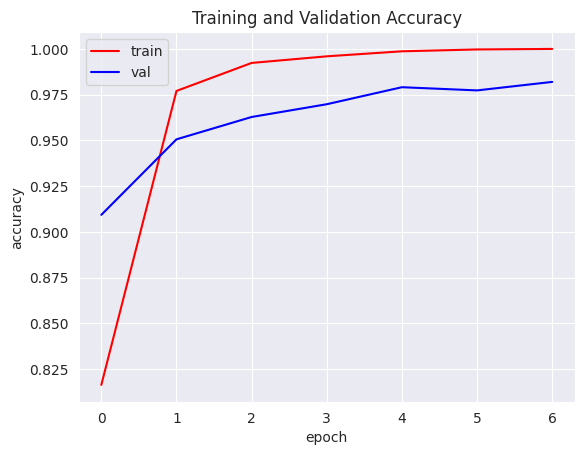

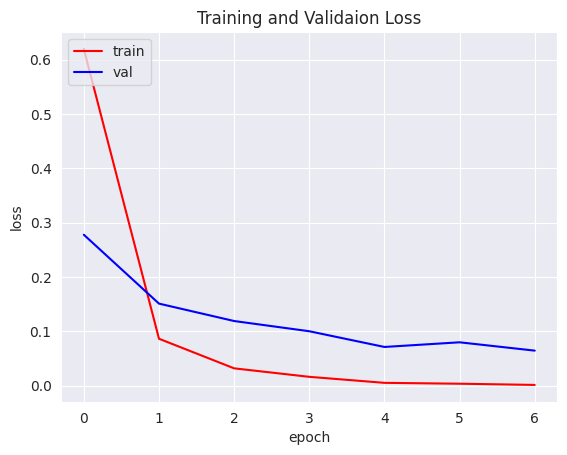

In [44]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

#### Konversi Model

In [45]:
save_path = 'model-tf/'
tf.saved_model.save(model_1, save_path)

In [46]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model /content/model-tf new-tfjs-model-revisi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-04-15 11:34:03.092003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744716843.111246    6233 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:17

In [50]:
!zip -r /content/model-tfjs.zip /content/new-tfjs-model-revisi/

  adding: content/new-tfjs-model-revisi/ (stored 0%)
  adding: content/new-tfjs-model-revisi/model.json (deflated 96%)
  adding: content/new-tfjs-model-revisi/group1-shard4of4.bin (deflated 7%)
  adding: content/new-tfjs-model-revisi/group1-shard3of4.bin (deflated 7%)
  adding: content/new-tfjs-model-revisi/group1-shard2of4.bin (deflated 7%)
  adding: content/new-tfjs-model-revisi/group1-shard1of4.bin (deflated 7%)


In [48]:
joblib.dump(model_1, '/content/drive/My Drive/Colab Notebooks/model-klasifikasi-gambar-capstone.joblib')

['/content/drive/My Drive/Colab Notebooks/model-klasifikasi-gambar-capstone.joblib']

# **inference**


In [49]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

model = joblib.load('/content/drive/My Drive/Colab Notebooks/model-klasifikasi-gambar-capstone.joblib')

def preprocess_image(image_path):
  img = image.load_img(image_path, target_size=(224, 224)) # Sesuaikan dengan ukuran input model
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.  # Normalisasi
  return img_array

def predict_image(image_path, model):
  img_array = preprocess_image(image_path)
  prediction = model.predict(img_array)
  predicted_class = np.argmax(prediction) # Ambil kelas dengan probabilitas tertinggi

  # Daftar kelas (sesuaikan dengan dataset Anda)
  class_names = ['aceh', 'bali_barong', 'bali_merak', 'dki', 'jabar', 'jatim', 'kalimantan', 'lampung', 'madura', 'maluku', 'ntb', 'papua_asmat', 'papua_cendrawasih', 'papua_tifa', 'solo', 'sulawesi', 'sumatera_barat', 'sumatera_utara', 'yogyakarta_kawung', 'yogyakarta_parang']

  predicted_class_name = class_names[predicted_class]
  return predicted_class_name

image_path = '/content/header_Screen_Shot_2024-10-06_at_18_37_53.png' # Ganti dengan path gambar yang ingin diprediksi
predicted_class = predict_image(image_path, model)
print(f"Gambar diprediksi sebagai: {predicted_class}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Gambar diprediksi sebagai: yogyakarta_parang
